In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

# Load and Prepare Data

In [2]:
red_train = pd.read_csv('red_train.csv')
red_test = pd.read_csv('red_test.csv')
white_train = pd.read_csv('white_train.csv')
white_test = pd.read_csv('white_test.csv')

In [17]:
red_train.shape

(1199, 12)

In [18]:
white_train.shape

(3673, 12)

In [7]:
red_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.8,0.44,0.47,2.50,0.063,9.0,28.0,0.99810,3.24,0.65,10.80,6
1,6.3,0.51,0.13,2.30,0.076,29.0,40.0,0.99574,3.42,0.75,11.00,6
2,8.5,0.18,0.51,1.75,0.071,45.0,88.0,0.99524,3.33,0.76,11.80,7
3,7.7,0.18,0.34,2.70,0.066,15.0,58.0,0.99470,3.37,0.78,11.80,6
4,6.2,0.65,0.06,1.60,0.050,6.0,18.0,0.99348,3.57,0.54,11.95,5


In [3]:
red_train_copy = red_train.copy()
red_test_copy = red_test.copy()
white_train_copy = white_train.copy()
white_test_copy = white_test.copy()
red_train_copy['type'] = 'red'
red_test_copy['type'] = 'red'
white_train_copy['type'] = 'white'
white_test_copy['type'] = 'white'

In [8]:
red_train_copy.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,9.8,0.44,0.47,2.50,0.063,9.0,28.0,0.99810,3.24,0.65,10.80,6,red
1,6.3,0.51,0.13,2.30,0.076,29.0,40.0,0.99574,3.42,0.75,11.00,6,red
2,8.5,0.18,0.51,1.75,0.071,45.0,88.0,0.99524,3.33,0.76,11.80,7,red
3,7.7,0.18,0.34,2.70,0.066,15.0,58.0,0.99470,3.37,0.78,11.80,6,red
4,6.2,0.65,0.06,1.60,0.050,6.0,18.0,0.99348,3.57,0.54,11.95,5,red


In [4]:
combined_train = pd.concat([red_train_copy, white_train_copy], axis = 0)
combined_test = pd.concat([red_test_copy, white_test_copy], axis = 0)
combined_train = pd.get_dummies(combined_train)
combined_test = pd.get_dummies(combined_test)

In [9]:
combined_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,9.8,0.44,0.47,2.50,0.063,9.0,28.0,0.99810,3.24,0.65,10.80,6,1,0
1,6.3,0.51,0.13,2.30,0.076,29.0,40.0,0.99574,3.42,0.75,11.00,6,1,0
2,8.5,0.18,0.51,1.75,0.071,45.0,88.0,0.99524,3.33,0.76,11.80,7,1,0
3,7.7,0.18,0.34,2.70,0.066,15.0,58.0,0.99470,3.37,0.78,11.80,6,1,0
4,6.2,0.65,0.06,1.60,0.050,6.0,18.0,0.99348,3.57,0.54,11.95,5,1,0


In [10]:
red_train_x = red_train.drop('quality', axis = 1)
red_train_y = red_train['quality']
red_test_x = red_test.drop('quality', axis = 1)
red_test_y = red_test['quality']
white_train_x = white_train.drop('quality', axis = 1)
white_train_y = white_train['quality']
white_test_x = white_test.drop('quality', axis = 1)
white_test_y = white_test['quality']
combined_train_x = combined_train.drop('quality', axis = 1)
combined_train_y = combined_train['quality']
combined_test_x = combined_test.drop('quality', axis = 1)
combined_test_y = combined_test['quality']

# Create Base XGBoost Models

## Red Model

In [12]:
red_model = xgb.XGBRegressor().fit(red_train_x, red_train_y)
mae = mean_absolute_error(red_test_y, red_model.predict(red_test_x))
print('MAE for red base model: ', mae)

MAE for red base model:  0.38551137268543245


## White Model

In [13]:
white_model = xgb.XGBRegressor().fit(white_train_x, white_train_y)
mae = mean_absolute_error(white_test_y, white_model.predict(white_test_x))
print('MAE for white base model: ', mae)

MAE for white base model:  0.47156560489109584


## Combined Model

In [16]:
combined_model = xgb.XGBRegressor().fit(combined_train_x, combined_train_y)
mae = mean_absolute_error(combined_test_y, combined_model.predict(combined_test_x))
print('MAE for combined base model: ', mae)

MAE for combined base model:  0.47515145565913275


# Tuning Models

## Red Model

In [19]:
start_time = time.time()
param_grid = {'max_depth': [2, 8, 14],
              'n_estimators': [50, 100, 500, 1000],
              'learning_rate': [0.001, 0.01, 0.1],
              'subsample': [0.5, 0.75, 1],
              'reg_lambda':[0, 1, 10],
              'gamma': [0, 10]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1, subsample = 0.5),                                                       
                             param_distributions = param_grid,
                                 n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_absolute_error')
grid_result = grid_search.fit(red_train_x, red_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


/Users/keatonolds/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.649099 using {'subsample': 0.5, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 14, 'learning_rate': 0.01, 'gamma': 0}
Time taken =  1.4288663029670716  minutes


In [21]:
start_time = time.time()
param_grid = {'max_depth': [12, 14, 16],
              'n_estimators': [1000, 2000, 3000],
              'learning_rate': [0.01, 0.025, 0.05],
              'subsample': [0.2, 0.35, 0.5],
              'reg_lambda':[0, 0.1, 0.2],
              'gamma': [0, 1]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1, subsample = 0.5),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_absolute_error')
grid_result = grid_search.fit(red_train_x, red_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 2 folds for each of 486 candidates, totalling 972 fits
Best: 0.673798 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 3000, 'reg_lambda': 0.1, 'subsample': 0.5}
Time taken =  7.955299270153046  minutes


In [22]:
start_time = time.time()
param_grid = {'max_depth': [14],
              'n_estimators': [3000, 3500, 4000],
              'learning_rate': [0.01],
              'subsample': [0.5],
              'reg_lambda':[0.1],
              'gamma': [0, 0.1, 0.5]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(random_state=1, subsample = 0.5),                                                       
                             param_grid = param_grid,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv,
                          scoring = 'neg_mean_absolute_error')
grid_result = grid_search.fit(red_train_x, red_train_y)

print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
print("Time taken = ",(time.time()-start_time)/60," minutes")

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: 0.673797 using {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 14, 'n_estimators': 4000, 'reg_lambda': 0.1, 'subsample': 0.5}
Time taken =  0.6000357151031495  minutes


>50 0.660 (0.018)
>500 0.662 (0.019)
>1000 0.662 (0.019)
>2000 0.662 (0.019)
>3000 0.662 (0.019)
>4000 0.662 (0.019)
>5000 0.662 (0.019)


Text(0.5, 0, 'Number of trees')

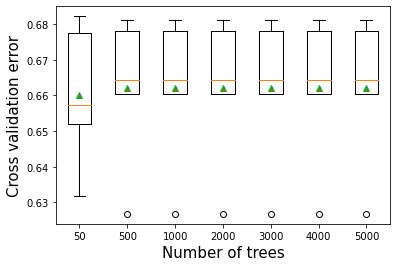

In [29]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [50, 500, 1000, 2000, 3000, 4000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, red_train_x, red_train_y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

In [ ]:
red_model_tuned = xgb.XGBRegressor(random_state = 1, gamma = 0, learning_rate = 0.01, max_depth = 14, n_estimators = 500,
                                  reg_lambda = 0.1, subsample = 0.5).fit(red_train_x, red_train_y)
mae = mean_absolute_error(red_test_y, red_model_tuned.predict(red_test_x))
print('MAE for red base model: ', mae)

## White Model

## Combined Model